In [1]:
import os
os.chdir(r"E:\adani")
try:
    inpath = "equalized_archive/" 
    print(os.listdir(inpath))
except FileNotFoundError:
    inpath = "./" 
    print(os.listdir(inpath))


['Data_Entry_2017.csv', 'equalized_images_001', 'equalized_images_002', 'equalized_images_003', 'equalized_images_004', 'equalized_images_005', 'equalized_images_006', 'equalized_images_007', 'equalized_images_008', 'equalized_images_009', 'equalized_images_010', 'equalized_images_011', 'equalized_images_012', 'test', 'train', 'val']


In [2]:
import pandas as pd
data = pd.read_csv(inpath + 'Data_Entry_2017.csv')
print(data.shape)

data.head()


(112120, 12)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [3]:
data = data[data['Patient Age']<100]

data.shape


(112104, 12)

In [4]:
data = data[['Image Index', 'Finding Labels']]

data.shape

(112104, 2)

In [5]:
from glob import glob
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('equalized_archive', 'equalized_images*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', data.shape[0])


data['Path'] = data['Image Index'].map(all_image_paths.get)

data.sample(5, random_state=3)

Scans found: 112120 , Total Headers 112104


,Image Index,Finding Labels,Path
13531,00003520_002.png,No Finding,equalized_archive\equalized_images_002\0000352...
45241,00011598_037.png,Effusion|Mass,equalized_archive\equalized_images_006\0001159...
40313,00010503_000.png,Infiltration,equalized_archive\equalized_images_005\0001050...
81272,00019962_006.png,No Finding,equalized_archive\equalized_images_009\0001996...
85415,00021047_013.png,No Finding,equalized_archive\equalized_images_010\0002104...


In [6]:
data['Disease'] = data.apply(lambda row : 0 if (row['Finding Labels'] == 'No Finding') else 1, axis = 1)
data.head()

,Image Index,Finding Labels,Path,Disease
0,00000001_000.png,Cardiomegaly,equalized_archive\equalized_images_001\0000000...,1
1,00000001_001.png,Cardiomegaly|Emphysema,equalized_archive\equalized_images_001\0000000...,1
2,00000001_002.png,Cardiomegaly|Effusion,equalized_archive\equalized_images_001\0000000...,1
3,00000002_000.png,No Finding,equalized_archive\equalized_images_001\0000000...,0
4,00000003_000.png,Hernia,equalized_archive\equalized_images_001\0000000...,1


In [7]:
label_counts = data['Disease'].value_counts()
label_counts

0    60353
1    51751
Name: Disease, dtype: int64

In [8]:
import numpy as np
from itertools import chain
all_labels = np.unique(data['Disease'])
all_labels = [x for x in all_labels]
all_labels

[0, 1]

In [9]:
from sklearn.model_selection import train_test_split

train_and_valid_df, test_df = train_test_split(data, 
                                   test_size = 0.30, 
                                   random_state = 2018)

train_df, valid_df = train_test_split(train_and_valid_df,
                                      test_size=0.30,
                                      random_state=2018)

print(f'Train {train_df.shape[0]} Validation {valid_df.shape[0]} Test: {test_df.shape[0]}')

Train 54930 Validation 23542 Test: 33632


In [10]:
train_counts = train_df['Disease'].value_counts()
valid_counts = valid_df['Disease'].value_counts()
test_counts = test_df['Disease'].value_counts()



In [11]:
train_counts.shape


(2,)

In [12]:
valid_counts.shape


(2,)

In [13]:
test_counts.shape


(2,)

In [14]:
for i in range(valid_counts.shape[0]-1):
    if(i in [10, 50, 100, valid_counts.shape[0]-2]):
        individual=f'TRAIN: {train_counts.to_numpy()[i]}\tVALID: {valid_counts.to_numpy()[i]}\tTEST: {test_counts.to_numpy()[i]}'
        total_split = f'\tSUM: {train_counts.to_numpy()[i] + valid_counts.to_numpy()[i] + test_counts.to_numpy()[i]}'
        total = f'\tEXPECTED: {label_counts.to_numpy()[i]}'
        print(individual, total_split, total)

TRAIN: 29580	VALID: 12763	TEST: 18010 	SUM: 60353 	EXPECTED: 60353


In [15]:
from keras_preprocessing.image import ImageDataGenerator
base_generator = ImageDataGenerator(rescale=1./255)

In [16]:
IMG_SIZE = (224, 224)
def flow_from_dataframe(image_generator, dataframe, batch_size):

    df_gen = image_generator.flow_from_dataframe(dataframe,
                                                 x_col='Path',
                                                 y_col='Disease',
                                                 target_size=IMG_SIZE,
                                                 color_mode='rgb',
                                                 class_mode='raw',
                                                 shuffle=False,
                                                 batch_size=batch_size)
    return df_gen

In [17]:
train_gen = flow_from_dataframe(image_generator=base_generator, 
                                dataframe= train_df,
                                batch_size = 32)

valid_gen = flow_from_dataframe(image_generator=base_generator, 
                                dataframe=valid_df,
                                batch_size = 32)

test_gen = flow_from_dataframe(image_generator=base_generator, 
                               dataframe=test_df,
                               batch_size = 32)

Found 54930 validated image filenames.
Found 23542 validated image filenames.
Found 33632 validated image filenames.


In [18]:
train_x, train_y = next(train_gen)
print(train_x[1].shape)
print(train_y[1])

(224, 224, 3)
0


In [19]:
from keras.layers import Input
from keras.applications.vgg16  import VGG16
from keras.layers.core import Dense, Dropout, Flatten
from keras.models import Model

input_shape=(224, 224, 3)
img_input = Input(shape=input_shape)

base_model = VGG16(weights='imagenet', include_top=False, input_tensor=img_input, input_shape=input_shape)
x = base_model.output
print(base_model.output_shape[1:])
x = Flatten(input_shape=base_model.output_shape[1:])(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(all_labels)-1, activation="sigmoid", name="predictions")(x)
model = Model(inputs=img_input, outputs=predictions)

Using TensorFlow backend.
D:\Anaconda3\envs\df_env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\df_env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\df_env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\df_env\lib\site-packages\tensorflow\python\framework\dtypes.py


(7, 7, 512)


In [20]:
from contextlib import redirect_stdout

with open('model_summary1.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()


In [21]:
from keras.optimizers import SGD
    
model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy', 'binary_accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import keras.callbacks as kcall
weight_path="{}_weights.best.hdf5".format('vgg16_rgb_binary_xray_class_equal')
weight_path

'vgg16_rgb_binary_xray_class_equal_weights.best.hdf5'

In [23]:
class LossHistory(kcall.Callback):
    def on_train_begin(self, logs={}):
        self.batch_losses = []
        self.batch_acc = []
        self.epochs_losses = []
        self.epochs_acc = []
        self.epochs_val_losses = []
        self.epochs_val_acc = []
        
    def on_batch_end(self, batch, logs={}):
        self.batch_losses.append(logs.get('loss'))
        self.batch_acc.append(logs.get('acc'))
        
    def on_epoch_end(self, epoch, logs={}):
        self.epochs_losses.append(logs.get('loss'))
        self.epochs_acc.append(logs.get('acc'))
        self.epochs_val_losses.append(logs.get('val_loss'))
        self.epochs_val_acc.append(logs.get('val_acc'))

In [24]:
history = LossHistory()

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)

callbacks_list = [checkpoint, early, history]
callbacks_list

In [25]:
epochs=20
history = model.fit_generator(
                    generator=train_gen,
                    steps_per_epoch=train_gen.n//train_gen.batch_size,
                    validation_data = valid_gen,
                    validation_steps=valid_gen.n//valid_gen.batch_size,
                    epochs = epochs,
                    callbacks = callbacks_list,
                    shuffle=False)


Epoch 1/20
1716/1716 [==============================] - 1298s 756ms/step - loss: 0.6275 - accuracy: 0.6568 - binary_accuracy: 0.6568 - val_loss: 0.6299 - val_accuracy: 0.6787 - val_binary_accuracy: 0.6787

Epoch 00001: val_loss improved from inf to 0.62988, saving model to vgg16_rgb_binary_xray_class_equal_weights.best.hdf5
Epoch 2/20
1716/1716 [==============================] - 1288s 751ms/step - loss: 0.6049 - accuracy: 0.6850 - binary_accuracy: 0.6850 - val_loss: 0.6419 - val_accuracy: 0.6940 - val_binary_accuracy: 0.6940

Epoch 00002: val_loss did not improve from 0.62988
Epoch 3/20
1716/1716 [==============================] - 1263s 736ms/step - loss: 0.5968 - accuracy: 0.6937 - binary_accuracy: 0.6937 - val_loss: 0.4962 - val_accuracy: 0.6922 - val_binary_accuracy: 0.6922

Epoch 00003: val_loss improved from 0.62988 to 0.49616, saving model to vgg16_rgb_binary_xray_class_equal_weights.best.hdf5
Epoch 4/20
1716/1716 [==============================] - 1264s 737ms/step - loss: 0.591

Text(0.5, 1.0, 'Training and Validation Loss')

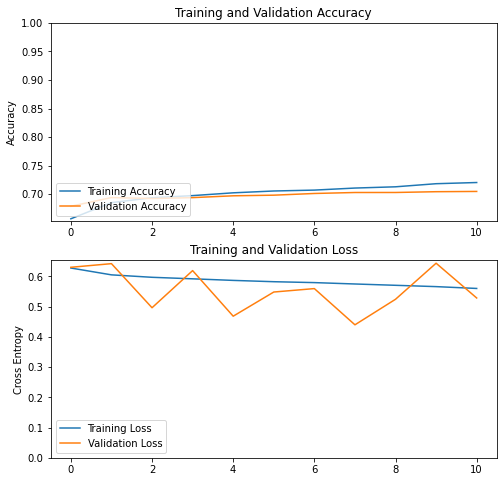

In [26]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')


In [27]:
test_shape = test_gen.n
batch = 32
result = test_shape/batch
print(result)
result*batch==test_gen.n

1051.0


True

In [29]:
model.load_weights(weight_path)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy', 'binary_accuracy'])

pred_y = model.predict_generator(test_gen, verbose = True)

1051/1051 [==============================] - 569s 541ms/step


In [30]:
print(pred_y.shape, test_gen.labels.shape)

(33632, 1) (33632,)


Confusion matrix:
[[13280  4730]
 [ 5416 10206]]
(0) 0
(1) 1


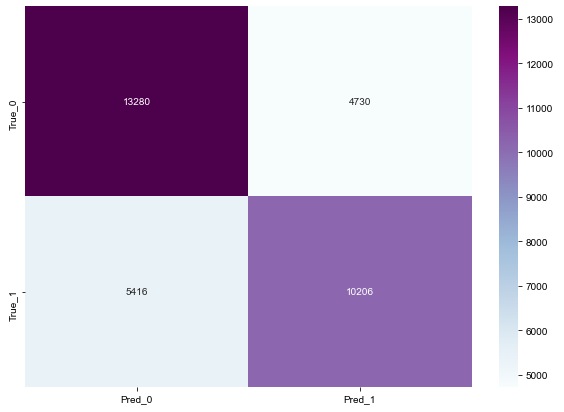

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
test_gen.reset()

cls_pred = np.rint(pred_y)
cls_test = np.array(test_gen.labels)

from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred,):

    cm = confusion_matrix(y_true=cls_test,  
                          y_pred=cls_pred) 

    print("Confusion matrix:")
    
    print(cm)
    
    for i, class_name in enumerate(all_labels):
        print("({0}) {1}".format(i, class_name))
        
    df_cm = pd.DataFrame(cm, index = ['True_'+str(i) for i in all_labels],
                  columns = ['Pred_'+str(i) for i in all_labels])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True,fmt="d",cmap="BuPu",annot_kws={"size": 10})# font size
    sns.set(font_scale=1)#for label size
    plt.show()
    
print_confusion_matrix(cls_pred)